KeyboardInterrupt: 

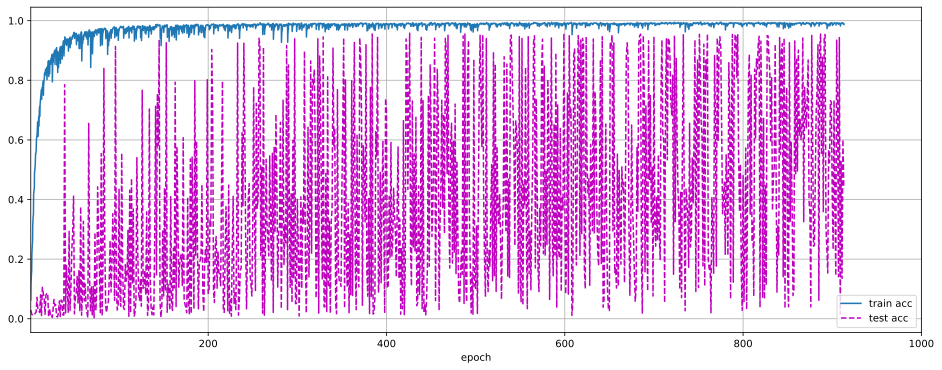

In [1]:
from torch.utils.data import dataloader
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
from data_utils import getData


class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)


b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True,
                         strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk


b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))


args = {
    'batch_size': 64,
    'model': 'seresnext101',
    'freeze': True,
    'eval_all': True,
    'data_root': '../dataset/classify-leaves',
    'val_ratio': 0.1
}
class AttributeDict(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
args = AttributeDict(args)
num_classes = 176

train_data, val_data = getData(args, mode='train')
train_loader = dataloader.DataLoader(
    train_data, args.batch_size, shuffle=True)
val_loader = dataloader.DataLoader(val_data, args.batch_size, shuffle=True)

net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, num_classes))


def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train acc', 'test acc'], figsize=(16, 6))
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            # 这个 l 是一个值，因为 nn.CrossEntropyLoss() 会把所有样本的 loss 加起来
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

lr, num_epochs, batch_size = 0.05, 1000, 256
train_ch6(net, train_loader, val_loader, num_epochs, lr, d2l.try_gpu())
torch.save(net.state_dict(), '../models/resnet.pth')
